In [ ]:
!pip install arch

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import matplotlib.pyplot as plt

In [18]:

# Step 1: Download IBM price data and compute log returns
IBM_dprice = yf.download('IBM', start="2015-01-01", end="2025-01-01", auto_adjust=True, interval='1wk')
IBM_dprice['log_return'] = 100 * np.log(IBM_dprice['Close'] / IBM_dprice['Close'].shift(1))
IBM_log_return = IBM_dprice['log_return'].dropna()

# Step 2: Fit an ARMA(0,0) model (i.e., a constant mean model) to the log returns
arma_model = ARIMA(IBM_log_return, order=(0, 0, 0))
arma_result = arma_model.fit()

# Forecast the next period mean return
forecast_series = arma_result.forecast(steps=1)
mean_forecast = forecast_series.iloc[0]
print("Forecasted mean return:", mean_forecast)

# Step 3: Estimate a GARCH(1,1) model on the ARMA residuals
residuals = arma_result.resid

mean_models = ['Constant', 'AR']
vols = ["GARCH", "EGARCH"]
dists = ['normal', 't']

results = []

for mean in mean_models:
    for dist in dists:
        for vol in vols:
            print("\nFitting GARCH model with mean model:", mean, "and distribution:", dist)
            # Use the current loop variable `dist` instead of `dists`
            garch_model = arch_model(residuals, mean=mean, vol=vol, lags=1 if mean=="AR" else 0, p=1, q=1, dist=dist)
            garch_result = garch_model.fit(disp='off')
            garch_forecast = garch_result.forecast(horizon=1)
            print(f"AIC {garch_result.aic}")

            print("Forecast:")
            print(f"mean {garch_forecast.mean.iloc[-1].values[0]} - variance {garch_forecast.variance.iloc[-1].values[0]}")
            sigma_forecast = np.sqrt(garch_forecast.variance.iloc[-1].values[0])
            print("Forecasted sigma:", sigma_forecast)

            if dist == 'normal':
                VaR = -mean_forecast + 1.65 * sigma_forecast
                print("The VaR at 95% confidence level (normal) is:", VaR)
            elif dist == 't':
                VaR = -mean_forecast + 2.353 * sigma_forecast
                print("The VaR at 95% confidence level (t) is:", VaR)

            results.append({'mean': mean, 'dist': dist, 'vol': vol, 'meanret': garch_forecast.mean.iloc[-1].values[0], 'aic': garch_result.aic, 'VaR': VaR})

[*********************100%***********************]  1 of 1 completed

Forecasted mean return: 0.1584099098265634

Fitting GARCH model with mean model: Constant and distribution: normal
AIC 2670.1887403024703
Forecast:
mean -0.006546763874503019 - variance 10.500866713650446
Forecasted sigma: 3.2405040832639673
The VaR at 95% confidence level (normal) is: 5.188421827558982

Fitting GARCH model with mean model: Constant and distribution: normal
AIC 2674.521679680584
Forecast:
mean -0.00542988079548213 - variance 11.60512310286345
Forecasted sigma: 3.4066292875602784
The VaR at 95% confidence level (normal) is: 5.462528414647895

Fitting GARCH model with mean model: Constant and distribution: t
AIC 2625.4772831533073
Forecast:
mean 0.09546207651955567 - variance 14.05741991021217
Forecasted sigma: 3.7493225935110157
The VaR at 95% confidence level (t) is: 8.663746152704858

Fitting GARCH model with mean model: Constant and distribution: t
AIC 2628.0786178860835
Forecast:
mean 0.08524745103661639 - variance 14.430632227363498
Forecasted sigma: 3.798767198363


/home/carlo/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-THU will be used.
  self._init_dates(dates, freq)
/home/carlo/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-THU will be used.
  self._init_dates(dates, freq)
/home/carlo/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-THU will be used.
  self._init_dates(dates, freq)


In [19]:
results_df = pd.DataFrame(results)
#print(results_df)

best_model = results_df.loc[results_df['aic'].idxmin()]

print(best_model)

mean                AR
dist                 t
vol              GARCH
meanret        0.12371
aic        2624.408508
VaR           8.625417
Name: 6, dtype: object


[*********************100%***********************]  1 of 1 completed


The VaR at 95% confidence level is: 2.95%


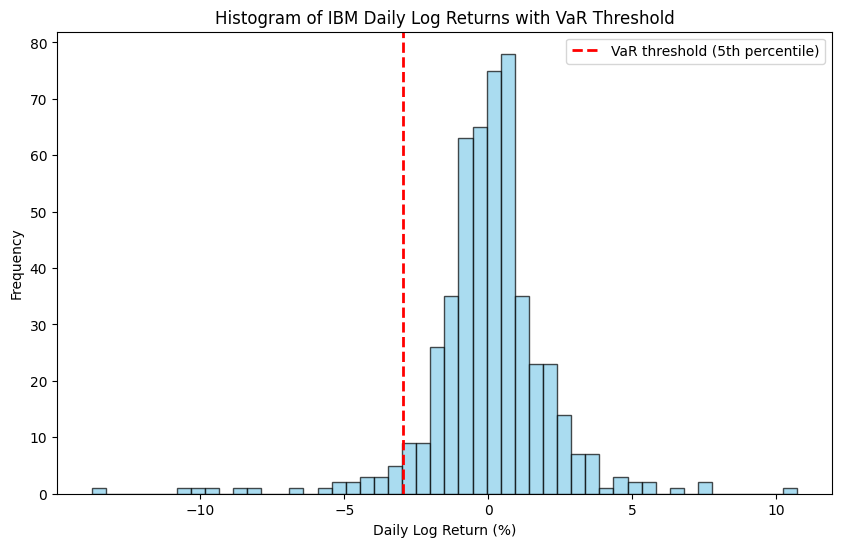

In [ ]:
# Step 1: Download IBM price data
IBM_dprice = yf.download('IBM', start="2020-01-01", end="2022-01-01", auto_adjust=True)

# Step 2: Compute daily log returns in percentage
IBM_dprice['log_return'] = 100 * np.log(IBM_dprice['Close'] / IBM_dprice['Close'].shift(1))
IBM_log_return = IBM_dprice['log_return'].dropna()  # Drop the first NaN

# Step 3: Define a function to calculate VaR using the quantile method
def calculate_VaR(returns, confidence_level=0.95):
    """
    Calculate Value at Risk (VaR) using the quantile method.

    Parameters:
        returns (array-like): Historical returns (losses should be negative).
        confidence_level (float): Confidence level (e.g., 0.95 for 95% confidence).

    Returns:
        float: VaR (expressed as a positive number representing the potential loss).
    """
    # Compute the quantile corresponding to the tail probability.
    # For a 95% confidence level, we take the 5th percentile.
    quantile_value = np.quantile(returns, 1 - confidence_level)

    # Since losses are negative, the VaR is the absolute value of this quantile.
    VaR = -quantile_value
    return VaR

# Set the desired confidence level
confidence_level = 0.95

# Calculate VaR for IBM using the computed log returns
VaR_value = calculate_VaR(IBM_log_return, confidence_level)
print(f"The VaR at {confidence_level*100:.0f}% confidence level is: {VaR_value:.2f}%")

# Step 4: Visualize the returns distribution and the VaR threshold
plt.figure(figsize=(10, 6))
plt.hist(IBM_log_return, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(np.quantile(IBM_log_return, 1 - confidence_level), color='red', linestyle='dashed', linewidth=2,
            label=f'VaR threshold (5th percentile)')
plt.title("Histogram of IBM Daily Log Returns with VaR Threshold")
plt.xlabel("Daily Log Return (%)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

